#### **Import Necessary Libraries :**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

#### **Load and Preprocess the Dataset :**

In [2]:
# Set paths and parameters

dataset_path = '/Users/kavu_rojasara/Downloads/caltech-101/101_ObjectCategories'
img_height, img_width = 224, 224  # Resizing to 224x224 for MobileNetV2
batch_size = 32

In [3]:
# Define ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2  
)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

# Load the validation data
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


### **Exploratory Data Analysis :**

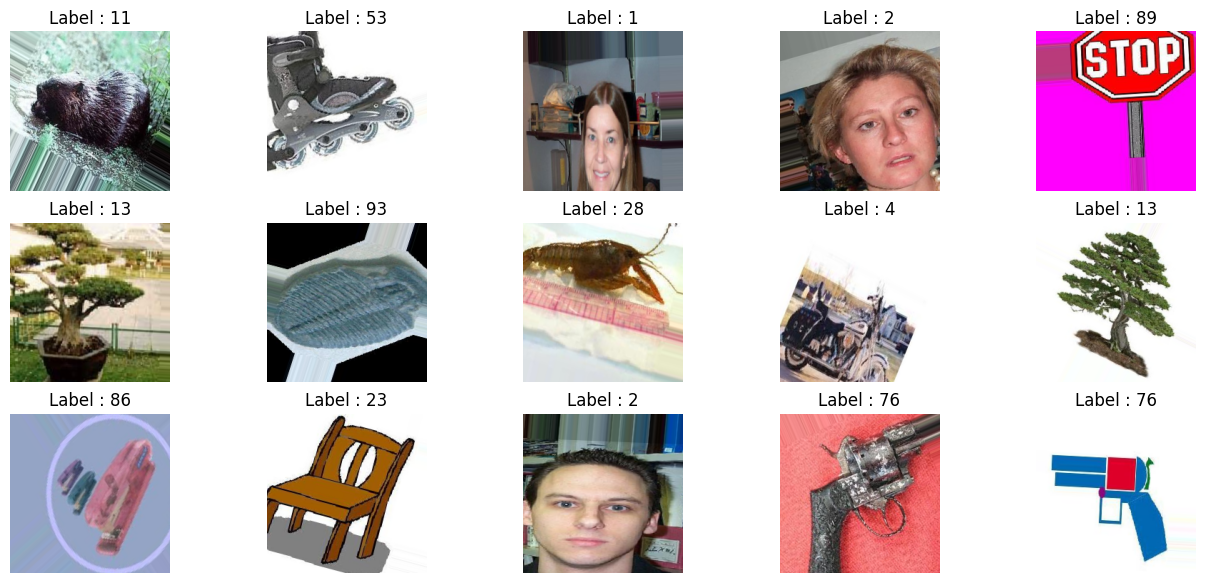

In [4]:
# Visualizing a few images from the training generator

def plot_images(generator):
    plt.figure(figsize = (16, 12))
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        img, label = next(generator)
        plt.imshow(img[0])
        plt.title(f'Label : {np.argmax(label[0])}')
        plt.axis('off')
    plt.show()

# Call the function to display images
plot_images(train_generator)

In [5]:
# Calculate class weights

class_weights = compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(train_generator.classes), 
    y = train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

### **Load Pre-trained Model and Feature Extraction :**

In [6]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(
    weights = '/users/kavu_rojasara/Downloads/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5',
    include_top = False,
    input_shape = (img_height, img_width, 3)
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

#### **Model Development :**

In [7]:
# Build the complete model with Dropout for regularization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dropout(0.5),  # Adding dropout to prevent overfitting
    Dense(len(train_generator.class_indices), activation = 'softmax')
])

# Set the input shape explicitly when building the model
model.build(input_shape = (None, img_height, img_width, 3))

# Compile the model with a reduced learning rate
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        26,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,612,134 (9.96 MB)

 Trainable params: 354,150 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### **Model Training :**

In [8]:
# Set up the EarlyStopping callback to monitor validation loss and prevent overfitting
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

# Train the model with Early Stopping
history = model.fit(
    train_generator,
    epochs = 50,  
    validation_data = validation_generator,
    callbacks = [early_stopping]
)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 62s 262ms/step - accuracy: 0.1263 - loss: 4.4463 - val_accuracy: 0.3876 - val_loss: 3.0300
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 62s 264ms/step - accuracy: 0.3581 - loss: 3.0803 - val_accuracy: 0.5358 - val_loss: 2.3200
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 64s 274ms/step - accuracy: 0.4663 - loss: 2.4447 - val_accuracy: 0.6331 - val_loss: 1.8186
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 65s 276ms/step - accuracy: 0.5511 - loss: 2.0180 - val_accuracy: 0.6924 - val_loss: 1.4743
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 66s 281ms/step - accuracy: 0.6221 - loss: 1.6443 - val_accuracy: 0.7422 - val_loss: 1.2441
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 67s 289ms/step - accuracy: 0.6546 - loss: 1.4709 - val_accuracy: 0.7438 - val_loss: 1.0948
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 72s 310ms/step - accuracy: 0.6854 - loss: 1.3070 - val_accuracy: 0.7718 - val_loss: 0.9899
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 71s 306ms/step - accuracy: 0.7192 - loss: 1

### **Fine-Tune the Model :**

In [9]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers 
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer = Adam(learning_rate = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    epochs = 10,  # Fine-tune for a few more epochs
    validation_data = validation_generator,
    class_weight = class_weights_dict,  
    callbacks = [early_stopping]
)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 98s 411ms/step - accuracy: 0.7570 - loss: 1.0522 - val_accuracy: 0.8579 - val_loss: 0.5461
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 94s 406ms/step - accuracy: 0.8219 - loss: 0.7718 - val_accuracy: 0.8423 - val_loss: 0.5682
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 93s 401ms/step - accuracy: 0.8233 - loss: 0.7513 - val_accuracy: 0.8462 - val_loss: 0.5698
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 95s 407ms/step - accuracy: 0.8438 - loss: 0.6536 - val_accuracy: 0.8372 - val_loss: 0.5784
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 93s 402ms/step - accuracy: 0.8413 - loss: 0.6443 - val_accuracy: 0.8389 - val_loss: 0.5850


#### **Model Evaluation :**

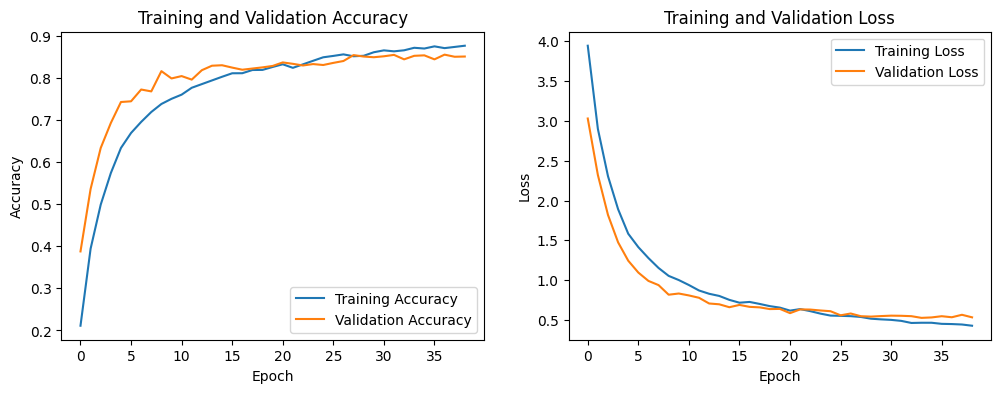

In [10]:
# Plot training and validation accuracy and loss

def plot_training_history(history):
    plt.figure(figsize = (12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label = 'Training Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

In [11]:
# Evaluate the model on the validation set

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy : {val_accuracy:.2f}')

56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.8277 - loss: 0.6328
Validation Accuracy : 0.85


### **Confusion Matrix and Classification Report :**

56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step


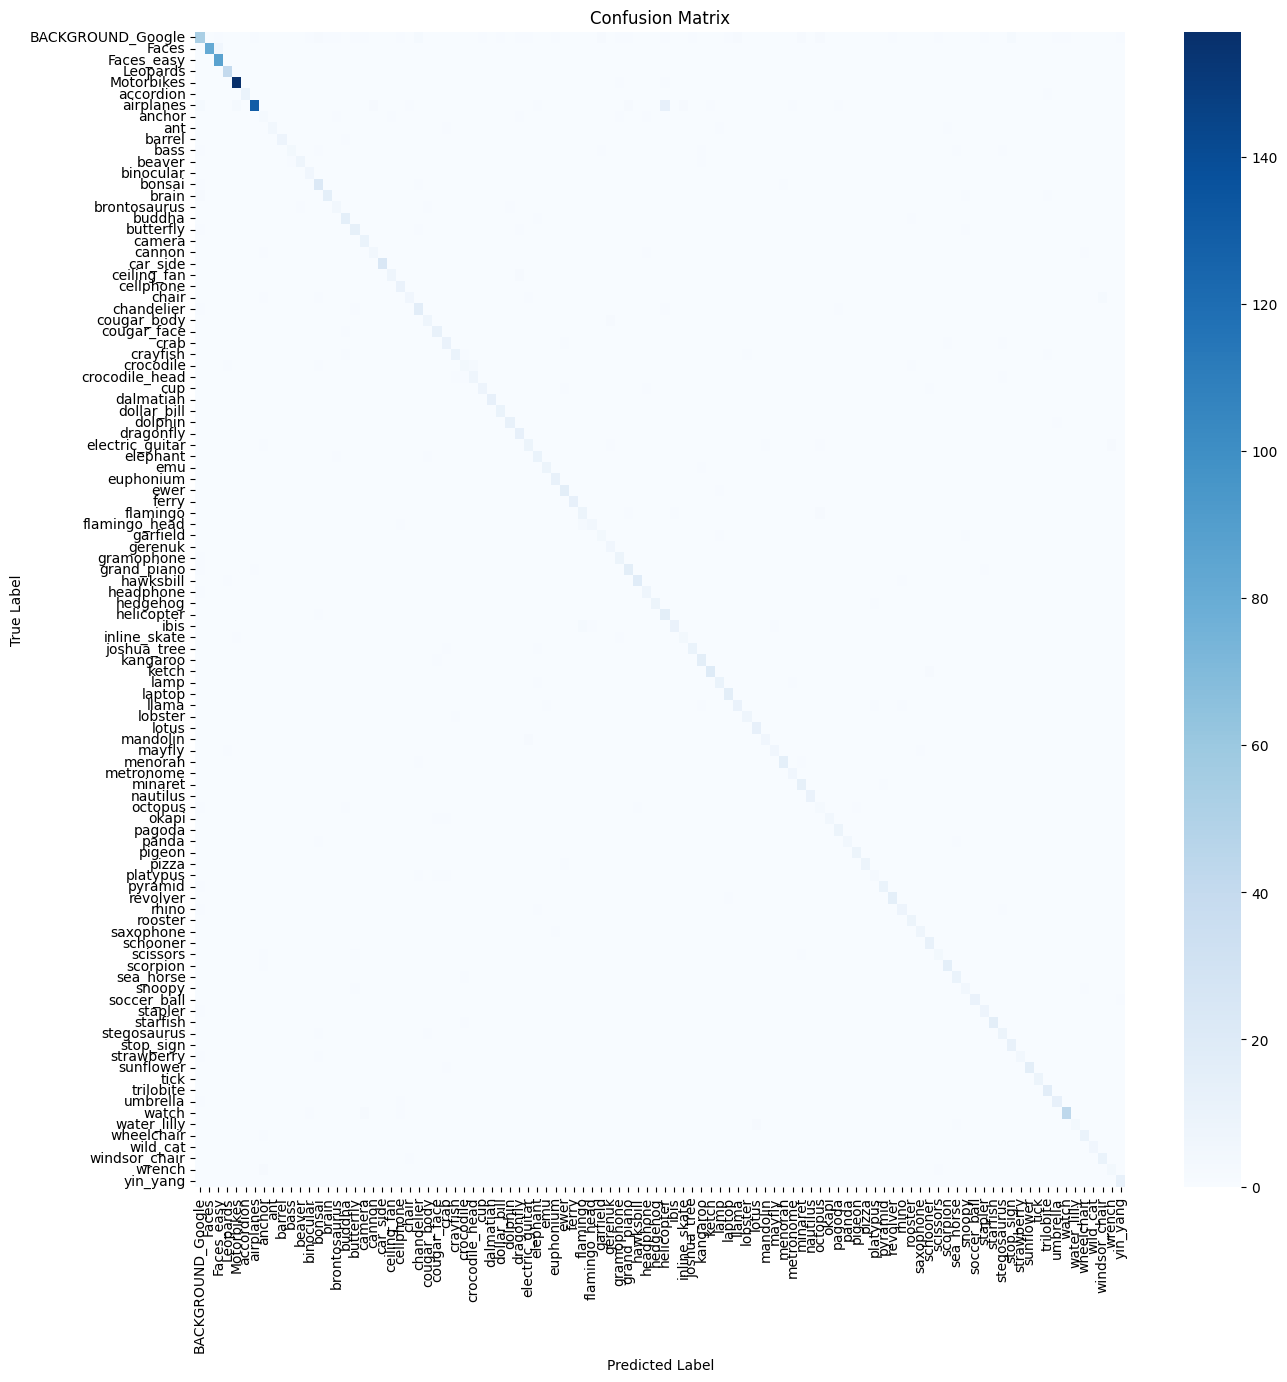

                   precision    recall  f1-score   support

BACKGROUND_Google       0.75      0.57      0.65        93
            Faces       1.00      0.93      0.96        87
       Faces_easy       0.93      1.00      0.96        87
         Leopards       0.93      1.00      0.96        40
       Motorbikes       0.98      0.99      0.98       159
        accordion       1.00      0.91      0.95        11
        airplanes       0.98      0.81      0.89       160
           anchor       0.27      0.38      0.32         8
              ant       1.00      0.62      0.77         8
           barrel       1.00      0.89      0.94         9
             bass       0.80      0.40      0.53        10
           beaver       0.88      0.78      0.82         9
        binocular       0.75      1.00      0.86         6
           bonsai       0.71      0.88      0.79        25
            brain       0.94      0.79      0.86        19
     brontosaurus       0.62      0.62      0.62       

In [12]:
# Generate predictions for the validation set
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, predicted_classes)
plt.figure(figsize = (15, 15))
sns.heatmap(cm, annot = False, fmt = "d", cmap = "Blues", 
            xticklabels = train_generator.class_indices.keys(), 
            yticklabels = train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
class_labels = list(train_generator.class_indices.keys())
report = classification_report(validation_generator.classes, predicted_classes, target_names = class_labels)
print(report)

### **Save the Model :**

In [14]:
# Save the model 

model.save('caltech101_mobilenetv2_classifier.keras')

56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step


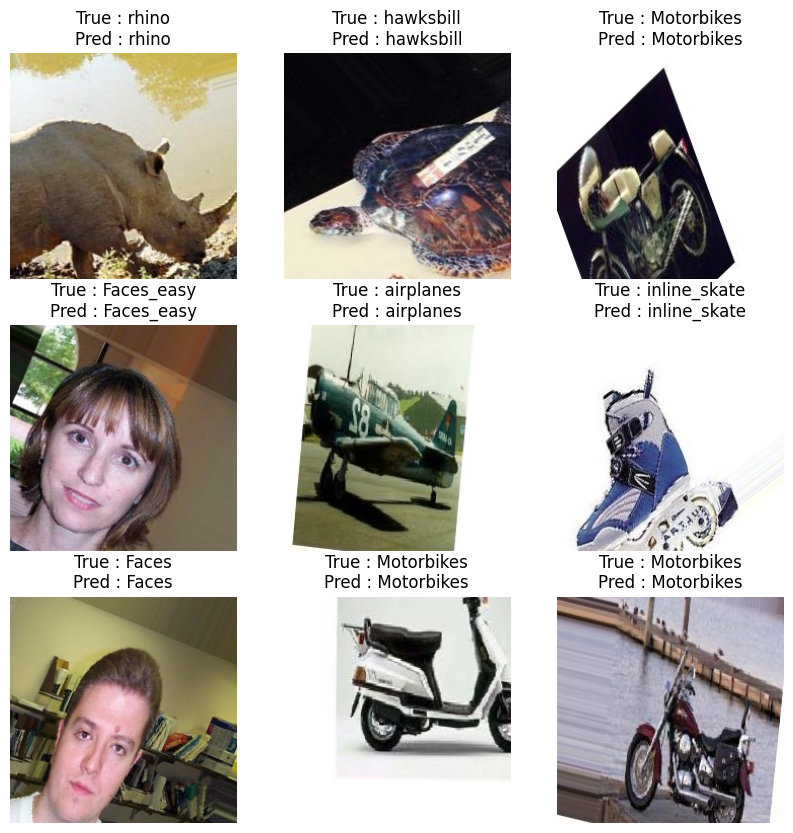

In [19]:
# Collect all images and labels from the validation generator
all_images = []
all_labels = []
validation_generator.reset()

for _ in range(len(validation_generator)):
    images, labels = next(validation_generator)
    all_images.extend(images)
    all_labels.extend(labels)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Predict on the entire validation set
predicted_classes = model.predict(all_images)
predicted_classes = np.argmax(predicted_classes, axis=1)

# Display 9 random images from the validation set
random_indices = random.sample(range(len(all_images)), 9)
plt.figure(figsize = (10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[idx])
    true_label = class_labels[np.argmax(all_labels[idx])]
    predicted_label = class_labels[predicted_classes[idx]]
    plt.title(f"True : {true_label}\nPred : {predicted_label}")
    plt.axis('off')
plt.show()